# Load libraries

In [6]:
LS = !ls
IS_KAGGLE = 'init.sh' not in LS
IS_KAGGLE

False

In [7]:
import sys

class CFG:
    seed = 4121995

if IS_KAGGLE:
    sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
    CFG.frames_path = ''
    CFG.utils_path = '/kaggle/input/nflutils'
    
    sys.path.insert(0, '../input/nflutils')
    !mkdir -p nflutils
    !cp ../input/nflutils/*.py nflutils/
    
else:
    CFG.frames_path = 'frames/content/work/frames/train'
    CFG.utils_path = 'nflutils'

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import pickle
import timm
import cv2

from pathlib import Path

from nflutils.dataprep import *

from tqdm.notebook import tqdm

from sklearn.metrics import matthews_corrcoef

import albumentations as A
from albumentations.pytorch import ToTensorV2

from fastai.vision.all import *

import wandb
from fastai.callback.wandb import *

pd.set_option('display.max_columns', 500)

# Read Files

In [9]:
if IS_KAGGLE:
    BASE_DIR = Path("../input/nfl-player-contact-detection")
    OUT_DIR = Path("/kaggle/working/")
else:
    BASE_DIR = Path("nfl-player-contact-detection")
    OUT_DIR = Path("nfl-player-contact-detection/frames")

In [10]:
ss = pd.read_csv(BASE_DIR/"sample_submission.csv")

# Player tracking data
te_tracking = pd.read_csv(
    BASE_DIR/"test_player_tracking.csv", parse_dates=["datetime"]
)

# Baseline helmet detection labels
te_helmets = pd.read_csv(BASE_DIR/"test_baseline_helmets.csv")

In [11]:
df_combo = pd.read_parquet(CFG.utils_path+'/df_combo.parquet')
df_combo_with_helmets = pd.read_parquet(CFG.utils_path+'/df_tracking_helmets_below_2.parquet')
df_combo_with_helmets['G_flag'] = np.where(df_combo_with_helmets.nfl_player_id_2 == 'G', 1, 0)

In [12]:
kf_dict = pickle.load(open('kf_dict', 'rb'))

## OOF Semi-final models

### Functions

In [8]:
def get_frames_df(df_combo, kf_dict, split, frames_path, offset=0, sample_every_n_frame=None, sample_every_n_frame_train=None, sample_every_n_frame_val=None, sample_train=None, sample_val=None, undersample_no_contact=False, filter_views=None, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_every_n_frame is not None:
        train_combo = train_combo.query('(290 - frame - @offset) % @sample_every_n_frame == 0')
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame == 0')
        
    if sample_every_n_frame_train is not None:
        train_combo = train_combo.query('(290 - frame -@offset) % @sample_every_n_frame_train == 0')
        
    if sample_every_n_frame_val is not None:
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame_val == 0')
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    frames_df = pd.concat([train_combo, val_combo], axis=0)
    frames_df.frame = frames_df.frame.astype('int') 
    
    if filter_views is not None:
        frames_df = frames_df.query('view in @filter_views')
        
    # frames_df['path'] = frames_df.apply(lambda x: get_frame_path(x, frames_path), axis=1)
        
    return frames_df


In [9]:
def get_interpolated_player_helmets(helmets_df, player_id):
    player_helmets = pd.DataFrame()
    tmp_frames_df = pd.DataFrame({'frame': np.arange(player_helmets_df.frame.min(), tr_helmets.frame.max()+1)})

    for view in helmets_df.view.unique():
        player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
        player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        player_helmets_view['view'] = view
        player_helmets = pd.concat([player_helmets, player_helmets_view], axis=0)
        
    return player_helmets

In [10]:
from torch.utils.data import Dataset, DataLoader
import functools

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame

def add_helmet(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left), int(row.top)),
                          (int(row.left+row.width), int(row.top+row.height)),
                          (255, 0, 0), 2)
    return frame

@functools.lru_cache(maxsize=500)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'

class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)


class NFLFrameTrackingDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
            
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)
    

def get_interpolated_player_helmets(helmets_df, tmp_frames_df, player_id, view):
    player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
    player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        
    return player_helmets_view

class NFL25DDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True, frames_offsets=[-6, 0, 6]):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
        self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in frames_df.game_play.unique()}
        self.frames_offsets = frames_offsets
        self.tmp_frames_df = pd.DataFrame({'frame': np.arange(270, 1500)})


        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        gp = row['game_play']
        view = row['view']
        
        player_1_id = int(row.nfl_player_id_1)
        player_2_id = int(row.nfl_player_id_2)
        
        player_1_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_1_id, view)
        player_2_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_2_id, view)
        
        frames = []
                
        for frame_offset in [-6, 0, 6]:
            frame_no = int(row.frame + frame_offset)
            frame_path = get_frame_path(frame_no, CFG.frames_path, gp, view)
            
            if os.path.exists(frame_path):
                frame = self.get_frame(frame_path)

                if self.helmets:
                    try:
                        player_1_frame_helmet = player_1_helmets.query('frame == @frame_no').iloc[0]
                        player_2_frame_helmet = player_2_helmets.query('frame == @frame_no').iloc[0]

                        frame = add_helmet(frame, player_1_frame_helmet)
                        frame = add_helmet(frame, player_2_frame_helmet)
                    except:
                        print(gp, player_1_id, view, frame_no)

                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

                frames.append(frame)
            
        if len(frames) < len(self.frames_offsets):
            frames = frames + frames[-1:]*(len(self.frames_offsets)-len(frames))
            
        frame = np.stack(frames, axis=-1)
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
            
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame

def crop_frames(frames, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frames = frames[:,
                            int(min_y):int(max_y), 
                            int(min_x):int(max_x),
                            :]
    return cropped_frames
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[-1][i].item()])
        plt.axis("off")
    plt.show()

In [11]:
def get_dls(df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
    frames_df = get_frames_df(df_combo, kf_dict, split, **frames_kwargs).copy()
    
    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    # train_frames_df.loc[(train_frames_df.nfl_player_id_2 == "G") & (train_frames_df.contact == 1)] = 2
    # val_frames_df.loc[(val_frames_df.nfl_player_id_2 == "G") & (val_frames_df.contact == 1)] = 2
    
    set_seed(frames_kwargs['seed'], True)

    train_ds = dl(train_frames_df, transform=train_transform, helmets=True, crop_size=crop_size)
    val_ds = dl(val_frames_df, transform=val_transform, helmets=True, crop_size=crop_size)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True,
    )
    
    data = DataLoaders(train_loader, val_loader, device=torch.device('cuda'))
    
    return data

In [12]:
class ShuffleGamePlayCallBack(Callback):
    def __init__(self, df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
        self.df_combo = df_combo
        self.kf_dict = kf_dict
        self.split = split
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.crop_size = crop_size
        self.bs = bs
        self.num_workers = 8
        self.frames_kwargs = frames_kwargs
        self.dl = dl
        
    def after_epoch(self):
        self.frames_kwargs['seed'] += 1
        self.frames_kwargs['offset'] += 1
        print(self.frames_kwargs['seed'], self.frames_kwargs['offset'])
        self.learn.dls = get_dls(self.df_combo, self.kf_dict, self.split, self.train_transform,
                                 self.val_transform, self.frames_kwargs, self.crop_size, self.bs, self.num_workers, self.dl)

In [13]:
class FrameTrackingModel(nn.Module):
    def __init__(self, arch='convnext_tiny', pretrained=True, n_in=3, concat_pool=True, mlp_n=64):
        super(FrameTrackingModel, self).__init__()
        
        model = timm.create_model(arch, pretrained=pretrained, num_classes=0, in_chans=n_in)
        self.body = TimmBody(model, pretrained, n_in=n_in)
        
        self.pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.mlp = nn.Sequential(
            nn.Linear(18, mlp_n),
            nn.LayerNorm(mlp_n),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.fc = nn.Linear(model.num_features*[1, 2][concat_pool]+mlp_n, 2)
        
    def forward(self, frame, feats):
        # print(frame.shape, feats.shape)
        x1 = self.body(frame)
        x1 = self.pool(x1)
        x1 = self.flatten(x1)
        x2 = self.mlp(feats)
        # print(x1.shape, x2.shape)
        return self.fc(torch.cat([x1, x2], dim=1))

### Player

#### Fold 0

In [32]:
split = 0
name = f'tiny-pp-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pp-folds', name=name, force=True)

accuracy,▁▅▂▆▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▁▄▃▆██
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
matthews_corrcoef,▁▄▃▆██
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
precision_score,▁▄▂▅▇█
raw_loss,█▆▇▅▅▅▅▄▄▅▄▅▆▃▄▆▅▅▄▄▄▄▅▂▃▃▂▂▁▃▂▂▂▁▂▁▁▁▃▃
recall_score,▆▃█▅▃▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [33]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [34]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, bs=64)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

In [35]:
learn.fit_one_cycle(10, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time


KeyboardInterrupt: 

In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [ ]:
learn.load(name)

In [ ]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull())].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameTrackingDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [ ]:
preds, _ = learn.get_preds(dl=test_loader)

In [ ]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [ ]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

#### Fold 1

In [23]:
split = 1
name = f'tiny-pp-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pp-folds', name=name, force=True)

In [24]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [25]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, bs=64)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

In [39]:
learn.fit_one_cycle(10, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.411693,0.329992,0.849594,0.572089,0.729110,0.610003,0.664260,12:40
1,0.421609,0.433806,0.795802,0.539591,0.859530,0.499816,0.632079,12:26
2,0.370589,0.398194,0.809514,0.559978,0.860736,0.520110,0.648410,12:26
3,0.329626,0.320514,0.851047,0.613148,0.828519,0.597367,0.694207,12:23
4,0.291527,0.288909,0.870290,0.632563,0.781830,0.651918,0.710988,12:24
5,0.265601,0.264399,0.885045,0.662098,0.775398,0.695979,0.733545,12:25
6,0.215249,0.312887,0.864946,0.640942,0.834721,0.627022,0.716116,12:25
7,0.179410,0.287682,0.880240,0.654511,0.785046,0.678547,0.727921,12:26
8,0.173684,0.292299,0.881611,0.651440,0.765348,0.688983,0.725161,12:28
9,0.151592,0.308209,0.877580,0.645431,0.774421,0.674149,0.720815,12:25


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5720886017197102.
44 2
45 3
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.613147606262977.
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.6325629496533268.
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6620982703535013.
49 7
50 8
51 9
52 10


In [40]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [26]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [27]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull())].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameTrackingDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [28]:
preds, _ = learn.get_preds(dl=test_loader)

43 1


In [29]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [30]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6608520094669332

#### Fold 2

In [31]:
split = 2
name = f'tiny-pp-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pp-folds', name=name, force=True)

In [32]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [33]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, bs=64)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

In [ ]:
learn.fit_one_cycle(10, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.409429,0.362415,0.823565,0.550796,0.790967,0.547750,0.647265,12:38
1,0.411230,0.380572,0.824469,0.545810,0.775979,0.550482,0.644063,12:37
2,0.362228,0.383659,0.821223,0.565664,0.833255,0.541058,0.656094,12:37
3,0.320284,0.353019,0.837081,0.598660,0.850318,0.568133,0.681157,12:39
4,0.285429,0.380842,0.834999,0.598244,0.857277,0.563710,0.680169,12:39
5,0.248035,0.333660,0.853308,0.614308,0.820074,0.604369,0.695889,12:35


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5507960403768054.
44 2
45 3
Better model found at epoch 2 with matthews_corrcoef value: 0.5656643549923849.
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.5986595829071742.
47 5
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6143078467555415.


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [34]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [35]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull())].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameTrackingDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [36]:
preds, _ = learn.get_preds(dl=test_loader)

43 1


In [37]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [38]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6391607388051681

#### Fold 3

In [39]:
split = 3
name = f'tiny-pp-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pp-folds', name=name, force=True)

In [40]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [41]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, bs=64)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name)
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

In [19]:
learn.fit_one_cycle(10, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.405825,0.399401,0.811319,0.519299,0.794217,0.497380,0.611688,12:28
1,0.400390,0.423955,0.785376,0.508137,0.848551,0.460140,0.596706,12:28
2,0.379182,0.437367,0.785727,0.516445,0.864164,0.461264,0.601478,12:24
3,0.320932,0.274592,0.880289,0.609128,0.688796,0.677041,0.682868,12:28
4,0.286101,0.296861,0.864981,0.612643,0.794779,0.606173,0.687780,12:28
5,0.245407,0.288142,0.876585,0.623911,0.760117,0.644275,0.697419,12:26
6,0.218815,0.276732,0.881949,0.632473,0.750187,0.663133,0.703979,12:23
7,0.187266,0.301475,0.875790,0.622624,0.761366,0.641665,0.696410,12:24
8,0.160561,0.327504,0.871922,0.617690,0.770610,0.628707,0.692463,12:18
9,0.145092,0.323837,0.875054,0.619255,0.756245,0.640756,0.693727,12:19


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5192992837092644.
44 2
45 3
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.6091282996998044.
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.612642659459303.
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6239106616283632.
49 7
Better model found at epoch 6 with matthews_corrcoef value: 0.6324730501286834.
50 8
51 9
52 10


In [20]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [42]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [43]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull())].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameTrackingDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [44]:
preds, _ = learn.get_preds(dl=test_loader)

43 1


In [45]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [46]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6288073728951612

#### Fold 4

In [47]:
split = 4
name = f'tiny-pp-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pp-folds', name=name, force=True)

In [48]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [49]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, bs=64)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

In [28]:
learn.fit_one_cycle(10, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.402735,0.466070,0.774336,0.509026,0.855106,0.473269,0.609308,12:12
1,0.416757,0.545992,0.695410,0.461277,0.937564,0.398073,0.558863,12:14
2,0.375256,0.358354,0.831348,0.566663,0.795643,0.563951,0.660056,12:13
3,0.313554,0.397667,0.817089,0.571149,0.857897,0.534637,0.658746,12:09
4,0.285263,0.404041,0.812781,0.580778,0.892543,0.526617,0.662404,12:10
5,0.246837,0.309494,0.866559,0.630391,0.793459,0.642289,0.709916,12:10
6,0.220869,0.326179,0.859255,0.625762,0.819307,0.619489,0.705523,12:10
7,0.191705,0.323336,0.868545,0.636464,0.799527,0.645900,0.714549,12:12
8,0.156977,0.337355,0.866934,0.632137,0.796311,0.642577,0.711232,12:11
9,0.167089,0.338820,0.870592,0.632064,0.774468,0.657565,0.711245,12:17


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5090255113068459.
44 2
45 3
Better model found at epoch 2 with matthews_corrcoef value: 0.5666634333507397.
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.57114872542535.
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.5807784932058084.
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6303910138892527.
49 7
50 8
Better model found at epoch 7 with matthews_corrcoef value: 0.636463979101644.
51 9
52 10


In [29]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [50]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [51]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull())].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameTrackingDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [52]:
preds, _ = learn.get_preds(dl=test_loader)

43 1


In [53]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [54]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6375199988295489

### Ground

#### Fold 0

In [14]:
split = 0
name = f'tiny-pg-fold-{split}'

In [19]:
split = 0
name = f'tiny-pg-fold-{split}'
wandb.init(project='nfl-1st-and-future', group='pg-folds', name=name, force=True)

accuracy,▁█▅▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▁█▅▃
lr_0,▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▇▇▇████████████████▇▇▇▇▇
matthews_corrcoef,▁█▅▃
mom_0,████▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
precision_score,▁█▄▂
raw_loss,█▅▆▄▄▃▃▅▂▂▃▃▃▃▁▃▁▁▂▁▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▂
recall_score,▆▁▄█
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [20]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [21]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_tiny', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [22]:
learn.fit_one_cycle(10, 4e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.392010,0.144282,0.954436,0.541380,0.720711,0.439583,0.546090,07:11
1,0.280953,0.103714,0.961765,0.583915,0.728806,0.498156,0.591801,07:28
2,0.189933,0.160408,0.937546,0.541476,0.873623,0.365613,0.515491,07:43
3,0.162506,0.138979,0.949792,0.585857,0.870250,0.422305,0.568658,07:52
4,0.126658,0.090652,0.970351,0.666808,0.800540,0.579805,0.672523,07:37
5,0.114268,0.122352,0.954650,0.612131,0.882617,0.450839,0.596822,07:53
6,0.095915,0.082341,0.971488,0.677436,0.807960,0.591635,0.683080,07:52
7,0.087857,0.089034,0.970975,0.680587,0.826625,0.583585,0.684162,07:47
8,0.075366,0.069347,0.978261,0.705078,0.721835,0.710963,0.716358,07:53
9,0.056456,0.071990,0.976739,0.703028,0.761862,0.671024,0.713564,08:08


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5413798590849446.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.5839152916779496.
45 3
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.5858567416728029.
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.6668079162558572.
48 6
49 7
Better model found at epoch 6 with matthews_corrcoef value: 0.6774362091590432.
50 8
Better model found at epoch 7 with matthews_corrcoef value: 0.6805874033428487.
51 9
Better model found at epoch 8 with matthews_corrcoef value: 0.7050780789382958.
52 10


In [23]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [ ]:
learn.load(name)

In [26]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [27]:
preds, _ = learn.get_preds(dl=test_loader)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [28]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [29]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.7046838483345863

#### Fold 1

In [30]:
split = 1
name = f'tiny-pg-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pg-folds', name=name, force=True)

In [31]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [32]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_tiny', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

SuggestedLRs(valley=0.0003981071640737355)

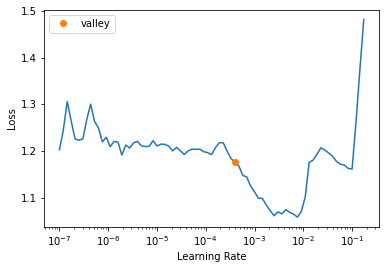

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(10, 4e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.410767,0.245787,0.902531,0.448746,0.834475,0.280112,0.419432,05:46
1,0.345449,0.225194,0.911458,0.502422,0.909627,0.311750,0.464355,05:47
2,0.188216,0.121067,0.958643,0.634069,0.842275,0.505943,0.632158,05:49
3,0.147789,0.076898,0.974489,0.698937,0.745434,0.680445,0.711458,05:46
4,0.120758,0.160173,0.940998,0.587400,0.907915,0.410036,0.564934,05:48
5,0.100673,0.075889,0.973509,0.707800,0.797755,0.652100,0.717611,05:47
6,0.087746,0.100986,0.965281,0.655311,0.804033,0.561893,0.661501,05:47
7,0.086815,0.112665,0.963178,0.666830,0.865868,0.539666,0.664913,05:47
8,0.073475,0.083455,0.972209,0.690395,0.773973,0.641438,0.701500,05:48
9,0.056341,0.081211,0.973734,0.696083,0.755708,0.666443,0.708274,05:48


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.44874624834190513.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.502421804442397.
45 3
Better model found at epoch 2 with matthews_corrcoef value: 0.634068691183282.
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.6989365968448054.
47 5
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.7077998689433206.
49 7
50 8
51 9
52 10


In [19]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [33]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [34]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [ ]:
preds, _ = learn.get_preds(dl=test_loader)

In [ ]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [ ]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

#### Fold 2

In [55]:
split = 2
name = f'tiny-pg-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pg-folds', name=name, force=True)

In [56]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [57]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_tiny', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [27]:
learn.fit_one_cycle(10, 4e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.380642,0.171728,0.947496,0.485805,0.695295,0.373554,0.486000,05:57
1,0.244649,0.163996,0.945627,0.510763,0.765202,0.372636,0.501199,05:58
2,0.178495,0.390476,0.822104,0.341662,0.930093,0.159172,0.271825,05:59
3,0.163838,0.097840,0.968785,0.602588,0.695739,0.549614,0.614104,05:58
4,0.126081,0.121591,0.955736,0.570358,0.800044,0.434809,0.563413,05:58
5,0.109120,0.094763,0.969830,0.591173,0.648247,0.567846,0.605389,05:58
6,0.072380,0.095593,0.970868,0.622954,0.707723,0.574698,0.634311,05:57
7,0.071671,0.099710,0.968594,0.624246,0.752996,0.543402,0.631256,06:00
8,0.065956,0.093966,0.972247,0.636239,0.714159,0.592306,0.647550,06:00
9,0.061154,0.088875,0.973760,0.640863,0.692632,0.618265,0.653339,05:58


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.48580522605759235.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.5107633899403468.
45 3
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.6025884280470544.
47 5
48 6
49 7
Better model found at epoch 6 with matthews_corrcoef value: 0.6229537942255049.
50 8
Better model found at epoch 7 with matthews_corrcoef value: 0.6242456527652926.
51 9
Better model found at epoch 8 with matthews_corrcoef value: 0.6362393162246319.
52 10
Better model found at epoch 9 with matthews_corrcoef value: 0.6408631549892669.


In [28]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [58]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [59]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [60]:
preds, _ = learn.get_preds(dl=test_loader)

43 1


In [61]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [62]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6383903709381271

#### Fold 3

In [63]:
split = 3
name = f'tiny-pg-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pg-folds', name=name, force=True)

In [64]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [65]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_tiny', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [36]:
learn.fit_one_cycle(10, 4e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.411220,0.197842,0.933317,0.495808,0.764267,0.359514,0.489001,05:43
1,0.236263,0.162423,0.941887,0.542921,0.802380,0.401838,0.535496,05:44
2,0.177731,0.157020,0.950238,0.591972,0.838879,0.448663,0.584639,05:44
3,0.150634,0.115567,0.962959,0.615257,0.742085,0.541097,0.625850,05:43
4,0.126214,0.162017,0.942830,0.580894,0.881629,0.413389,0.562858,05:44
5,0.112541,0.127020,0.957074,0.626430,0.847348,0.491807,0.622380,05:44
6,0.091744,0.146342,0.949809,0.605244,0.874773,0.448187,0.592704,05:43
7,0.068291,0.118940,0.964221,0.647899,0.806211,0.548648,0.652948,05:43
8,0.064207,0.124873,0.962167,0.640225,0.816294,0.530468,0.643050,05:44
9,0.047738,0.120191,0.962698,0.639447,0.806816,0.535322,0.643610,05:43


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.4958084394059081.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.5429212668359377.
45 3
Better model found at epoch 2 with matthews_corrcoef value: 0.5919724088621491.
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.6152571724677346.
47 5
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6264304111134427.
49 7
50 8
Better model found at epoch 7 with matthews_corrcoef value: 0.6478993570016734.
51 9
52 10


In [37]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [66]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [67]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [68]:
preds, _ = learn.get_preds(dl=test_loader)

43 1


In [69]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [70]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6441514735854122

#### Fold 4

In [71]:
split = 4
name = f'tiny-pg-fold-{split}'
# wandb.init(project='nfl-1st-and-future', group='pg-folds', name=name, force=True)

In [72]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [73]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_tiny', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, split, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [45]:
learn.fit_one_cycle(10, 4e-4)

43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5048228524764763.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.520638108717711.
45 3
46 4
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.6232283139164713.
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6413905929369962.
49 7
Better model found at epoch 6 with matthews_corrcoef value: 0.6496941159881423.
50 8
Better model found at epoch 7 with matthews_corrcoef value: 0.6614613341631429.
51 9
52 10


In [46]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [74]:
learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [75]:
val_games = kf_dict[split]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [76]:
preds, _ = learn.get_preds(dl=test_loader)

43 1


In [77]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [78]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6606114653136125

### OOF Score

In [37]:
from nflutils.validation import *

In [48]:
oof_df_p = pd.DataFrame()

for i in range(0, 5):
    oof_df_p = pd.concat([oof_df_p, pd.read_parquet(f'tiny-pp-fold-{i}.parquet')], axis=0)

In [49]:
oof_df_g = pd.DataFrame()

for i in range(0, 5):
    oof_df_g = pd.concat([oof_df_g, pd.read_parquet(f'tiny-pg-fold-{i}.parquet')], axis=0)

In [82]:
matthews_corrcoef(oof_df_p.contact, oof_df_p.contact_pred > 0.5)

0.6449854838881407

In [83]:
matthews_corrcoef(oof_df_g.contact, oof_df_g.contact_pred > 0.5)

0.6689076700311953

In [51]:
oof_df = pd.concat([oof_df_p, oof_df_g], axis=0)

In [89]:
matthews_corrcoef(oof_df.contact, oof_df.contact_pred > 0.5)

0.6760869221154314

In [53]:
oof_df['thresh'] = 0.5

In [54]:
oof_df_combo = merge_combo_val(df_combo, oof_df, pred_col='contact_pred')
get_matthews_corrcoef(oof_df_combo, pred_col='contact_pred', dist=0.5)

0.7256455976795063

In [57]:
oof_df[['contact_id', 'game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'step', 'contact', 'contact_pred', 'view', 'distance']].to_parquet('nflutils/oof_preds_raw.parquet', index=False)

In [56]:
oof_df_combo[['contact_id', 'game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'step', 'contact', 'contact_pred', 'distance']].to_parquet('nflutils/oof_df.parquet', index=False)

In [ ]:
oof_df_p = smooth_predictions(oof_df_p, True, [14])

  0%|          | 0/22461 [00:00<?, ?it/s]

In [ ]:
oof_df_g = smooth_prediction(oof_df_g, True, [56])

In [58]:
%%time

oof_df_p['contact_pred_rolling'] =  oof_df_p.groupby(['game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'view'])['contact_pred'].transform(lambda x: x.rolling(22, center=True).mean().bfill().ffill().fillna(0))

CPU times: user 17 s, sys: 152 ms, total: 17.2 s
Wall time: 17.2 s


In [59]:
%%time

oof_df_g['contact_pred_rolling'] =  oof_df_g.groupby(['game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'view'])['contact_pred'].transform(lambda x: x.rolling(56, center=True).mean().bfill().ffill().fillna(0))

CPU times: user 8.48 s, sys: 27.5 ms, total: 8.51 s
Wall time: 8.51 s


In [60]:
oof_df_p['thresh'] = 0.49
oof_df_g['thresh'] = 0.4

In [61]:
oof_df = pd.concat([oof_df_p, oof_df_g], axis=0)

In [62]:
oof_df_combo = merge_combo_val(df_combo, oof_df, pred_col='contact_pred_rolling')
get_matthews_corrcoef(oof_df_combo, pred_col='contact_pred_rolling', dist=0.5)

0.7377263009600805

In [63]:
oof_df[['contact_id', 'game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'step', 'contact', 'contact_pred', 'distance', 'view']].to_parquet('nflutils/oof_preds_rolling.parquet', index=False)

In [64]:
oof_df_combo[['contact_id', 'game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'step', 'contact', 'contact_pred', 'distance']].to_parquet('nflutils/oof_df_rolling.parquet', index=False)

In [33]:
oof_df_p.query('contact == 1').head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,distance_1,direction_1,orientation_1,acceleration_1,sa_1,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,datetime_ngs,view,frame,player_label_1,left_1,width_1,top_1,height_1,player_label_2,left_2,width_2,top_2,height_2,top,left,bottom,right,center_y,center_x,G_flag,contact_pred
288,58173_003606_6_43345_46183,58173_003606,2020-09-13 19:45:13.100000+00:00,6,43345,46183,1,65.78,23.71,2.76,0.25,242.39,107.97,4.37,4.37,66.45,23.18,3.2,0.31,248.31,268.98,2.52,2.52,0.854283,2020-09-13 19:45:13.100000+00:00,Sideline,332,V65,315.0,18.0,396.0,18.0,H93,351.0,19.0,400.0,20.0,396.0,315.0,420.0,370.0,408.0,342.0,0,0.938520
289,58173_003606_6_43345_46183,58173_003606,2020-09-13 19:45:13.100000+00:00,6,43345,46183,1,65.78,23.71,2.76,0.25,242.39,107.97,4.37,4.37,66.45,23.18,3.2,0.31,248.31,268.98,2.52,2.52,0.854283,2020-09-13 19:45:13.100000+00:00,Sideline,333,V65,313.0,18.0,396.0,18.0,H93,347.0,20.0,400.0,21.0,396.0,313.0,421.0,367.0,408.0,340.0,0,0.960398
290,58173_003606_6_43345_46183,58173_003606,2020-09-13 19:45:13.100000+00:00,6,43345,46183,1,65.78,23.71,2.76,0.25,242.39,107.97,4.37,4.37,66.45,23.18,3.2,0.31,248.31,268.98,2.52,2.52,0.854283,2020-09-13 19:45:13.100000+00:00,Sideline,334,V65,311.0,18.0,396.0,18.0,H93,344.0,20.0,401.0,22.0,396.0,311.0,423.0,364.0,409.0,337.0,0,0.950915
291,58173_003606_6_43345_46183,58173_003606,2020-09-13 19:45:13.100000+00:00,6,43345,46183,1,65.78,23.71,2.76,0.25,242.39,107.97,4.37,4.37,66.45,23.18,3.2,0.31,248.31,268.98,2.52,2.52,0.854283,2020-09-13 19:45:13.100000+00:00,Sideline,335,V65,309.0,18.0,396.0,18.0,H93,341.0,19.0,401.0,20.0,396.0,309.0,421.0,360.0,408.0,334.0,0,0.960584
292,58173_003606_6_43345_46183,58173_003606,2020-09-13 19:45:13.100000+00:00,6,43345,46183,1,65.78,23.71,2.76,0.25,242.39,107.97,4.37,4.37,66.45,23.18,3.2,0.31,248.31,268.98,2.52,2.52,0.854283,2020-09-13 19:45:13.100000+00:00,Sideline,336,V65,308.0,17.0,396.0,18.0,H93,338.0,19.0,401.0,21.0,396.0,308.0,422.0,357.0,409.0,332.0,0,0.962953


In [42]:
sample_df = oof_df_p.query('game_play == "58173_003606"').copy()

In [45]:
sample_df['contact_pred_rolling'] = sample_df.groupby(['game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'view'])['contact_pred'].transform(lambda x: x.rolling(22, center=True).mean().bfill().ffill().fillna(0))

<AxesSubplot:>

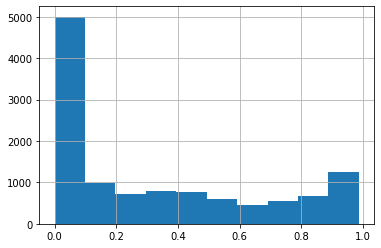

In [47]:
sample_df.contact_pred_rolling.hist()